# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [16]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder,Imputer,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [17]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [6]:
azdias.shape

(891221, 85)

In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [9]:
feat_info.shape

(85, 4)

In [10]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [18]:
feat_info_copy=feat_info.copy()

In [19]:
total_missing_percent=(azdias.isnull().sum().sum()/np.product(azdias.shape))*100
print('total_missing_percent : {}%'.format(total_missing_percent))
naturally_missing_percent=(azdias.isnull().mean()*100).sort_values(ascending=False)
print(naturally_missing_percent)

total_missing_percent : 6.464149613118342%
KK_KUNDENTYP             65.596749
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4              14.959701
KBA05_BAUMAX             14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
REGIOTYP                 13.598872
KKK                      13.598872
PLZ8_ANTG3               13.073637
PLZ8_ANTG1               13.073637
PLZ8_GBZ                 13.073637
PLZ8_ANTG2               13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
W_KEIT_KIND_HH           12.073549
KBA13_ANZAHL_PKW         11.871354
CAMEO_INTL_2015          11.106000
CAMEO_DEU_2015           11.106000
CAMEO_DEUG_2015          11.106000
ORTSGR_KLS9              10.908181
ARBEIT                   10.908181
RELAT_AB                 10.908181
ANZ_HH_TITEL             10.884842
BALLRAUM                 10.518154
EWDICHTE    

In [20]:
for idx in range(len(feat_info_copy)):
    M_O_U=feat_info_copy.iloc[idx].missing_or_unknown.strip("[]").split(',')
    M_O_U=[int(elem) if (elem!='XX' and elem!='X' and elem!='') else elem for elem in M_O_U]
    if M_O_U!=['']:
        azdias=azdias.replace({feat_info_copy.iloc[idx]['attribute']:M_O_U},np.nan)
    

In [21]:
total_missing_percent=(azdias.isnull().sum().sum()/np.product(azdias.shape))*100
print('total_missing_percent : {}%'.format(total_missing_percent))
missing_data_percent_after_replacement=(azdias.isnull().mean()*100).sort_values(ascending=False)
print(missing_data_percent_after_replacement)

total_missing_percent : 11.05413940702765%
TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [22]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

s1=pd.Series(azdias.isna().sum()/len(azdias)*100,name='Missing_Percent')
s2=pd.Series(azdias.columns.values)
for_hist=pd.DataFrame(s1,index=s2)
for_hist.sort_values(by='Missing_Percent',ascending=False,inplace=True)

In [23]:
len(azdias.isna().sum()[azdias.isna().sum()>0])

61

Text(0,0.5,'Number of columns')

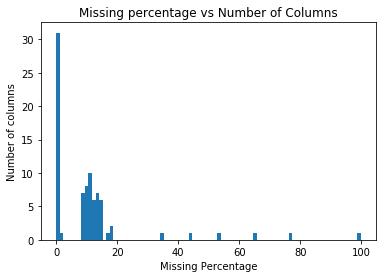

In [24]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(s1,bins=85)
plt.title('Missing percentage vs Number of Columns')
plt.xlabel('Missing Percentage')
plt.ylabel('Number of columns')

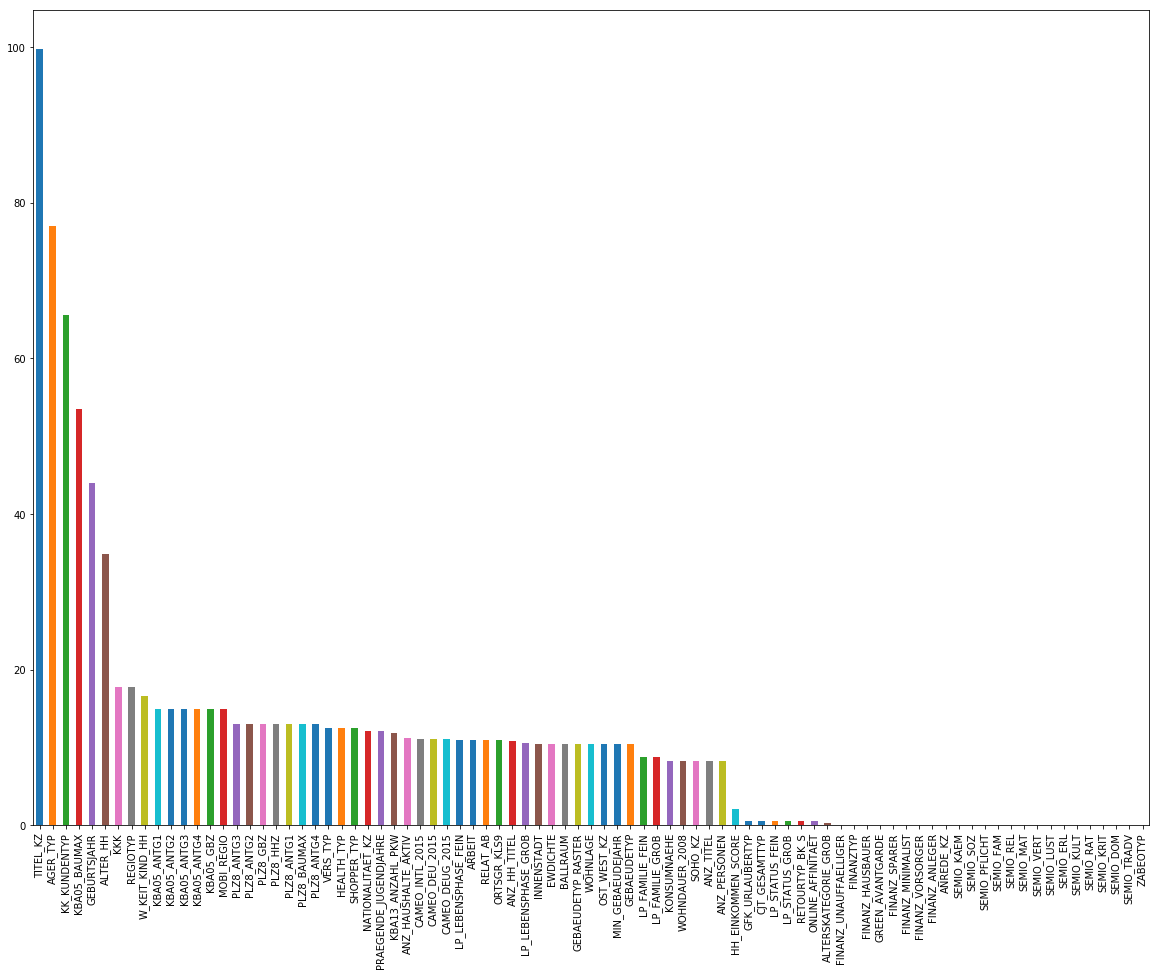

In [25]:
for_hist.Missing_Percent.plot.bar(figsize=(20,15))

In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

drop_cols_name=for_hist[for_hist['Missing_Percent']>20].index.tolist()
azdias.drop(columns=drop_cols_name,inplace=True)

In [27]:
drop_cols_name

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [28]:
for_hist.drop(drop_cols_name,inplace=True)
len(for_hist)

79

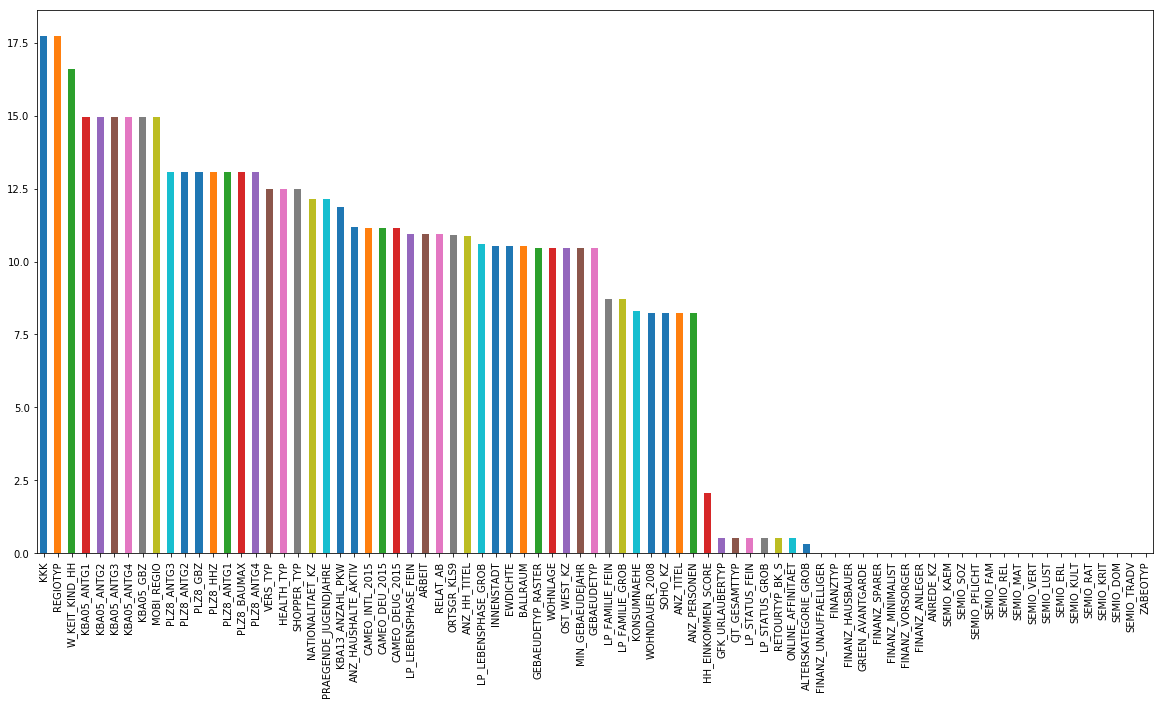

In [29]:
for_hist.Missing_Percent.plot.bar(figsize=(20,10))

In [30]:
feat_info_copy.set_index('attribute',drop=False,inplace=True)
feat_info_copy.drop(drop_cols_name,inplace=True)

In [31]:
feat_info.shape

(85, 4)

In [32]:
feat_info_copy.shape

(79, 4)

#### Discussion 1.1.2: Assess Missing Data in Each Column

1) Total missing values percentage before and after replacement are nearly 6.5% and 11.05% respectively.

2) As I have calculated the naturally missing percent and missing percent after replacement, I observed that in naturally missing data KK_KUNDENTYP was having highest missing percent 65.59% whereas after replacement TITEL_KZ ia having highest missing data with 99.75%. Similarly trend for other features can also be seen in above cells for each feature.

3) There are 61 features whose data is missing, after investigating the features with the help of matplotlib histogram, we observed that 6 features are having much higher missing percentage values i.e they are outliers.
['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']

4) Therefore, as recommended it is better to drop these features in order to do further analysis of the data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [33]:
missing_data_row_percent=len(azdias.isna().sum(axis=1)[azdias.isna().sum(axis=1)>0])/len(azdias)*100
no_missing_data_row_percent=len(azdias.isna().sum(axis=1)[azdias.isna().sum(axis=1)==0])/len(azdias)*100
print(missing_data_row_percent)
print(no_missing_data_row_percent)

30.07245116531141
69.9275488346886


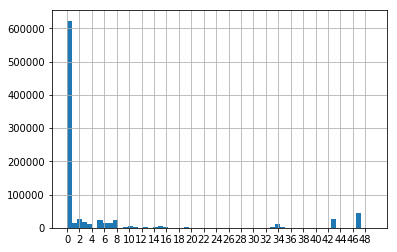

In [34]:
# How much data is missing in each row of the dataset?
missing_data_row=azdias.isna().sum(axis=1)
plt.hist(missing_data_row,bins=60)
plt.xticks(np.arange(0,50,2))
plt.grid()

In [35]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_less_missing=azdias[azdias.isna().sum(axis=1)<=20]
azdias_more_missing=azdias[azdias.isna().sum(axis=1)>20]

In [36]:
print(len(azdias_less_missing))
print(len(azdias_more_missing))

797426
93795


In [37]:
no_missing_cols=for_hist[for_hist.Missing_Percent==0].index.tolist()
six_cols=random.choices(no_missing_cols,k=6)

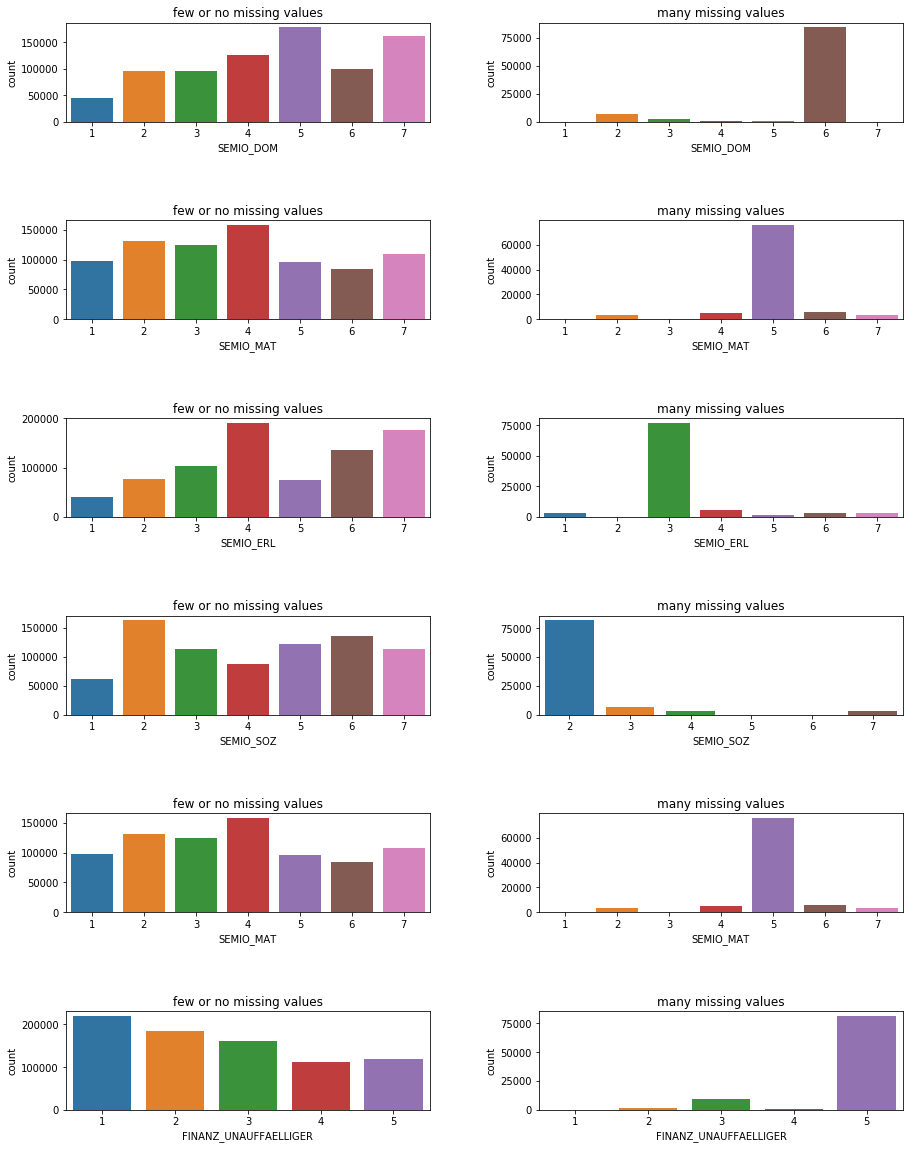

In [38]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
figures,axes=plt.subplots(nrows=6,ncols=2,figsize=(15,20))
figures.subplots_adjust(hspace = 1, wspace=.3)
for i in range(6):
    sns.countplot(azdias_less_missing[six_cols[i]],ax=axes[i][0])
    axes[i][0].set_title("few or no missing values")
    sns.countplot(azdias_more_missing[six_cols[i]],ax=axes[i][1])
    axes[i][1].set_title("many missing values")



#### Discussion 1.1.3: Assess Missing Data in Each Row

1) Nearly, 30% of the row data were missing from the dataset and rest nearly 70% rows doesn't have missing data.

2) From the histogram we observed that major number of rows are missing with features less than or equal to 20, so I took 20 as my threshold and divided the dataset based on it. If we take very less number of features such as 2 or 3 to split our dataset since it's looking like many rows are missing only 2-3 features, we may end up with loss of useful information.  

3) Next I compared the divided dataset of 'few or no missing values' and 'many missing values' with the columns which has no missing values, I took randomly 6 columns for comparison.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [39]:
# How many features are there of each data type?

feat_info_copy.groupby(by='type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_names=feat_info_copy[feat_info_copy.type=='categorical'].index.tolist()
categorical_names_binary=[x for x in categorical_names if len(set(azdias_less_missing[x]))==2]
categorical_names_multi=[x for x in categorical_names if len(set(azdias_less_missing[x]))>2]

In [41]:
categorical_names_binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

In [42]:
# Re-encode categorical variable(s) to be kept in the analysis.
 
le = LabelEncoder() 
for i in categorical_names_binary:
    if type(azdias_less_missing[i].values[0])==str:
        azdias_less_missing[i]= le.fit_transform(azdias_less_missing[i])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
azdias_less_missing.shape

(797426, 79)

In [44]:
categorical_names_multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [45]:
azdias_less_missing.drop(columns=categorical_names_multi,axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.2.1: Re-Encode Categorical Features

I re-encoded the binary categorical features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']  using labelencoder and dropped the multi-level categorical features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

## From Data_Dictionary.md


### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [46]:
feat_info_copy.loc["PRAEGENDE_JUGENDJAHRE"]

attribute             PRAEGENDE_JUGENDJAHRE
information_level                    person
type                                  mixed
missing_or_unknown                   [-1,0]
Name: PRAEGENDE_JUGENDJAHRE, dtype: object

In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def interval_var(val):
    try:
        if val in (1,2):
            return 1
        if val in (3,4):
            return 2
        if val in (5,6,7):
            return 3
        if val in (8,9):
            return 4
        if val in (10,11,12,13):
            return 5
        if val in (14,15):
            return 6
    except ValueError:
        return np.nan



def movement(val):
    try:
        if val in (2,4,6,7,9,11,13,15):
            return 0
        if val in (1,3,5,8,10,12,14):
            return 1
    except ValueError:
        return np.nan



In [48]:
azdias_less_missing['decade']=azdias_less_missing['PRAEGENDE_JUGENDJAHRE'].apply(interval_var)
azdias_less_missing['movement']=azdias_less_missing['PRAEGENDE_JUGENDJAHRE'].apply(movement)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [49]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def wealth(val):
    val=float(val)
    try:
        if val//10==1:
            return 1
        if val//10==2:
            return 2
        if val //10==3:
            return 3
        if val //10==4:
            return 4
        if val //10==5:
            return 5
    except ValueError:
        return np.nan
    
def lifestage(val):
    val=float(val)
    try:
        if val%10==1:
            return 1
        if val%10==2:
            return 2
        if val%10==3:
            return 3
        if val%10==4:
            return 4
        if val%10==5:
            return 5
    except ValueError:
        return np.nan
    


In [50]:
azdias_less_missing['wealth']=azdias_less_missing['CAMEO_INTL_2015'].apply(wealth)

azdias_less_missing['life_stage']=azdias_less_missing['CAMEO_INTL_2015'].apply(lifestage)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
mixed=[x for x in feat_info_copy.index.values if feat_info_copy.loc[x].type=='mixed']
print(mixed)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


#### Discussion 1.2.2: Engineer Mixed-Type Features

"PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" are mixed type features which were required to have some special treatment to inculcate them in the subsequent analysis procedure. Therefore, as suggested we mapped the values by checking into the Data_Dictionary.md and split the two features into 4 features by using apply().

I have decided to drop mixed features from further analysis process just to keep simplicity in the model.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [52]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

mixed_cols=[x for x in feat_info_copy.index.values if feat_info_copy.loc[x].type=='mixed']


In [53]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_less_missing.drop(columns=mixed_cols,axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [54]:
azdias_updated=azdias_less_missing.copy()

In [55]:
azdias_updated.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [56]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info_copy=feat_info.copy()
    
    for idx in range(len(feat_info_copy)):
        M_O_U=feat_info_copy.iloc[idx].missing_or_unknown.strip("[]").split(',')
        M_O_U=[int(elem) if (elem!='XX' and elem!='X' and elem!='') else elem for elem in M_O_U]
        if M_O_U!=['']:
            df=df.replace({feat_info_copy.iloc[idx]['attribute']:M_O_U},np.nan) 
    
    # remove selected columns and rows, ...
    ###dropping columns 
    drop_cols_name=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(columns=drop_cols_name,inplace=True)
    
    
    feat_info_copy.set_index('attribute',drop=False,inplace=True)
    feat_info_copy.drop(drop_cols_name,inplace=True)
    
    ###dropping rows
    df_less_missing=df[df.isna().sum(axis=1)<=20]
    
    # select, re-encode, and engineer column values.
    categorical_names=feat_info_copy[feat_info_copy.type=='categorical'].index.tolist()
    categorical_names_binary=[x for x in categorical_names if len(set(df_less_missing[x]))==2]
    categorical_names_multi=[x for x in categorical_names if len(set(df_less_missing[x]))>2] 
    
    le = LabelEncoder() 
    for i in categorical_names_binary:
        if type(df_less_missing[i].values[0])==str:
            df_less_missing[i]= le.fit_transform(df_less_missing[i])

    df_less_missing.drop(columns=categorical_names_multi,axis=1,inplace=True)

    df_less_missing['decade']=df_less_missing['PRAEGENDE_JUGENDJAHRE'].apply(interval_var)
    df_less_missing['movement']=df_less_missing['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    df_less_missing['wealth']=df_less_missing['CAMEO_INTL_2015'].apply(wealth)
    df_less_missing['life_stage']=df_less_missing['CAMEO_INTL_2015'].apply(lifestage)

    mixed_cols=[x for x in feat_info_copy.index.values if feat_info_copy.loc[x].type=='mixed']
    df_less_missing.drop(columns=mixed_cols,axis=1,inplace=True)
    df_cleaned=df_less_missing.copy()
    # Return the cleaned dataframe.
    return df_cleaned
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [57]:
azdias_updated.shape

(797426, 63)

In [58]:
azdias_updated.isnull().sum().sum()

715462

In [59]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
impute=Imputer(strategy='most_frequent')
azdias_updated_nan=pd.DataFrame(impute.fit_transform(azdias_updated))

azdias_updated_nan.shape

(797426, 63)

In [60]:
azdias_updated_nan.isnull().sum().sum()

0

In [61]:
type(azdias_updated.index)

pandas.core.indexes.numeric.Int64Index

In [62]:
type(azdias_updated_nan.index)

pandas.core.indexes.range.RangeIndex

In [63]:
azdias_updated_nan.index=azdias_updated.index
azdias_updated_nan.columns=azdias_updated.columns

In [64]:
azdias_updated_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [65]:
# Apply feature scaling to the general population demographics data.

scale=StandardScaler()
azdias_updated_scaled=pd.DataFrame(data=scale.fit_transform(azdias_updated_nan),columns=azdias_updated_nan.columns.tolist())

In [66]:
azdias_updated_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,-1.766334,0.958071,-1.494609,1.538200,-1.040726,1.466448,0.959677,1.338816,-0.530567,1.010368,...,0.441766,1.455006,0.573846,-0.171603,-0.127145,0.684744,1.098531,0.530567,1.175734,-1.249157
1,0.200589,0.958071,-1.494609,0.864824,-1.766955,-0.570799,0.244962,1.338816,1.884775,1.010368,...,-0.935489,0.419154,0.573846,-0.171603,-0.127145,-0.789154,1.098531,-1.884775,-0.869674,0.766845
2,1.184051,0.958071,0.683150,-0.481928,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.311674,...,-0.935489,-0.616697,0.573846,-1.173369,-0.997689,-0.052205,-0.267356,0.530567,-1.551476,-0.577156
3,0.200589,-1.043765,0.683150,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,1.010368,...,0.441766,-0.616697,-0.337337,0.830164,0.308127,1.421694,-0.267356,0.530567,0.493932,0.094845
4,-1.766334,0.958071,-0.042770,-1.155304,1.137960,-0.570799,-0.469752,1.338816,-0.530567,1.010368,...,0.441766,1.455006,1.485029,-1.173369,-0.997689,-0.052205,-1.633243,0.530567,1.175734,0.766845


### Discussion 2.1: Apply Feature Scaling

1) I dropped the remaining mixed features from the dataset, as they were not required in further analysis and may give false results.

2) By using Imputer function I have removed all the remaining null values from the dataset, by replacing them with the most frequent values.

3) I scaled the data using StandardScaler() so that it can become comparable values for features.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [67]:
# Apply PCA to the data.
pca=PCA()
azdias_updated_pca=pca.fit_transform(azdias_updated_scaled)

In [68]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
       # ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    



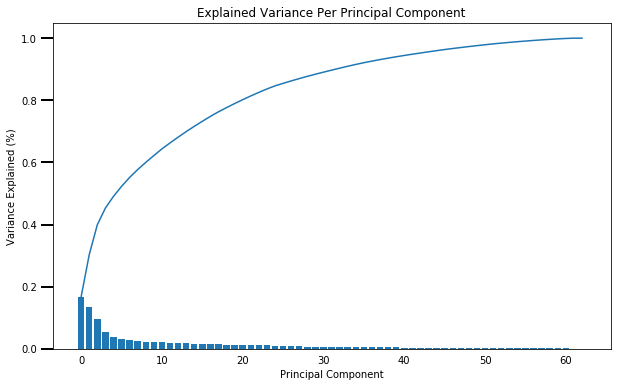

In [69]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca)

In [70]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_40=PCA(n_components=40)
azdias_pca=pca_40.fit_transform(azdias_updated_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

Observing the scree plot above, it is clear that after 40 features we can get 85% variance.So, I chose 40 components as principal components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [71]:
azdias_pca.shape

(797426, 40)

In [72]:
pca_40.components_.shape

(40, 63)

In [73]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def weights(pca, i):
    eigenvectors = pd.DataFrame(pca.components_, columns=list(azdias_updated_scaled.columns))
    weights = eigenvectors.iloc[i].sort_values(ascending=False)
    return weights

In [74]:
weight_first=weights(pca_40,0)
weight_first

PLZ8_ANTG3               0.225113
PLZ8_ANTG4               0.216707
wealth                   0.204511
HH_EINKOMMEN_SCORE       0.202140
ORTSGR_KLS9              0.196389
EWDICHTE                 0.194206
FINANZ_HAUSBAUER         0.159226
FINANZ_SPARER            0.153800
KBA05_ANTG4              0.153789
PLZ8_ANTG2               0.153456
ARBEIT                   0.142393
KBA05_ANTG3              0.136674
ANZ_HAUSHALTE_AKTIV      0.135870
RELAT_AB                 0.134715
SEMIO_PFLICHT            0.121968
SEMIO_REL                0.119497
decade                   0.112947
movement                 0.110250
SEMIO_RAT                0.100503
SEMIO_TRADV              0.094804
SEMIO_MAT                0.083795
FINANZ_UNAUFFAELLIGER    0.081817
SEMIO_FAM                0.081650
SEMIO_KULT               0.076372
FINANZ_ANLEGER           0.075766
REGIOTYP                 0.060357
SEMIO_SOZ                0.043543
PLZ8_HHZ                 0.042129
HEALTH_TYP               0.040359
KKK           

In [75]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_second=weights(pca_40,1)
weights_second

ALTERSKATEGORIE_GROB     0.256059
SEMIO_ERL                0.229831
FINANZ_VORSORGER         0.228709
SEMIO_LUST               0.179836
RETOURTYP_BK_S           0.161748
FINANZ_HAUSBAUER         0.122589
SEMIO_KRIT               0.117781
SEMIO_KAEM               0.116840
W_KEIT_KIND_HH           0.114899
PLZ8_ANTG3               0.099529
EWDICHTE                 0.098558
ORTSGR_KLS9              0.097340
PLZ8_ANTG4               0.097230
ANREDE_KZ                0.093649
wealth                   0.080225
KBA05_ANTG4              0.075926
SEMIO_DOM                0.074545
ARBEIT                   0.072484
RELAT_AB                 0.069845
PLZ8_ANTG2               0.068854
ANZ_HAUSHALTE_AKTIV      0.067085
HH_EINKOMMEN_SCORE       0.062834
FINANZ_MINIMALIST        0.058392
WOHNDAUER_2008           0.058138
KBA05_ANTG3              0.051234
ANZ_HH_TITEL             0.032219
movement                 0.018985
PLZ8_HHZ                 0.015944
REGIOTYP                 0.012242
ANZ_TITEL     

In [76]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_third=weights(pca_40,2)
weights_third

SEMIO_VERT               0.344671
SEMIO_SOZ                0.261865
SEMIO_FAM                0.248853
SEMIO_KULT               0.233800
FINANZ_MINIMALIST        0.154520
RETOURTYP_BK_S           0.109157
FINANZ_VORSORGER         0.101783
W_KEIT_KIND_HH           0.085207
ALTERSKATEGORIE_GROB     0.079814
SEMIO_REL                0.067751
SEMIO_LUST               0.064629
SEMIO_MAT                0.055680
ORTSGR_KLS9              0.050286
EWDICHTE                 0.049491
PLZ8_ANTG4               0.049148
PLZ8_ANTG3               0.048480
GREEN_AVANTGARDE         0.047077
ARBEIT                   0.037333
RELAT_AB                 0.034344
PLZ8_ANTG2               0.032707
WOHNDAUER_2008           0.032599
wealth                   0.030201
KBA05_ANTG4              0.029982
ANZ_HAUSHALTE_AKTIV      0.026809
ANZ_HH_TITEL             0.013931
KBA05_ANTG3              0.011848
ANZ_TITEL                0.009710
PLZ8_HHZ                 0.005566
SOHO_KZ                  0.000173
KBA05_ANTG2   

### Discussion 2.3: Interpret Principal Components

From taking the reference from Data_Dictionary.md, I interpret it as:

1) First component is having population density and financial status of a person. Positive values PLZ8 feature and Household features like HH_EINKOMMEN_SCORE shows that person is living in high population density area with good average household net income, whereas negative values of these kind of features implies just opposite of it.

2) Second Component is related to generation an culture, where negative values implies that of younger age with no savings and less religious affinity, whereas positive values implies of older people with less financial status.

3) Third component is related to gender, where positive values of features are associated with SEMIO_VERT (dreamful), SEMIO_SOZ (socially-minded). Whereas negative values of features are associated with ANREDE_KZ (female), SEMIO_DOM (dominant minded).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

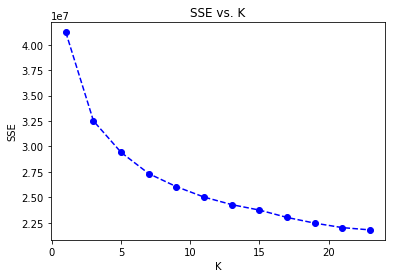

In [65]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.

def get_kmeans_score(data,center):
    kmeans=KMeans(n_clusters=center)
    model=kmeans.fit(data)
    score=np.abs(model.score(data))
    return score

scores=[]
centers=list(range(1,25,2))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca,center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
    

In [77]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans=KMeans(n_clusters=15)
model_15=kmeans.fit(azdias_pca)
gen_pop_pred=model_15.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

By using elbow method we observed that after 15 there isn't much change in the SSE values, therefore, I chose 15 number of clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [78]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [79]:
customers_updated=clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-p

In [80]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_updated_nan=pd.DataFrame(impute.transform(customers_updated))
customers_updated_nan.index=customers_updated.index
customers_updated_nan.columns=customers_updated.columns
customers_updated_scaled=pd.DataFrame(data=scale.transform(customers_updated_nan),columns=customers_updated_nan.columns.tolist())
# Apply PCA to the data.
customers_pca=pca_40.transform(customers_updated_scaled)

In [81]:
customers_pred=model_15.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

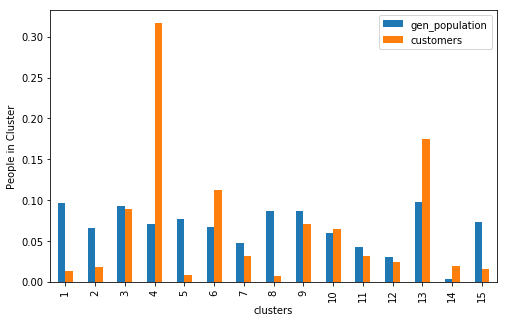

In [82]:
clusters=[]
gen_pop=[]
customers=[]

for i in list(range(0,15)):
    gen_pop.append((gen_pop_pred==i).sum()/len(gen_pop_pred))
    customers.append((customers_pred==i).sum()/len(customers_pred))
    clusters.append(i+1)
    
df=pd.DataFrame({'clusters':clusters,
                 'gen_population':gen_pop,
                 'customers':customers},)

df.plot(x='clusters',y=['gen_population','customers'],kind='bar',figsize=(8,5))
plt.ylabel('People in Cluster')
plt.show()

In [84]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_4=scale.inverse_transform(pca_40.inverse_transform(model_15.cluster_centers_[3]))
customers_cluster_4=pd.Series(data=cluster_4,index=customers_updated_scaled.columns)
customers_cluster_4

ALTERSKATEGORIE_GROB        3.295839
ANREDE_KZ                   1.039877
FINANZ_MINIMALIST           4.804864
FINANZ_SPARER               1.637545
FINANZ_VORSORGER            4.198629
FINANZ_ANLEGER              1.543044
FINANZ_UNAUFFAELLIGER       2.193450
FINANZ_HAUSBAUER            1.936101
GREEN_AVANTGARDE            0.988176
HEALTH_TYP                  2.081992
RETOURTYP_BK_S              3.992195
SEMIO_SOZ                   4.893426
SEMIO_FAM                   4.664260
SEMIO_REL                   3.732016
SEMIO_MAT                   3.882260
SEMIO_VERT                  6.295911
SEMIO_LUST                  5.348227
SEMIO_ERL                   4.002426
SEMIO_KULT                  5.004096
SEMIO_RAT                   2.761110
SEMIO_KRIT                  3.147533
SEMIO_DOM                   3.521733
SEMIO_KAEM                  2.560311
SEMIO_PFLICHT               3.076773
SEMIO_TRADV                 3.159202
SOHO_KZ                     0.008710
ANZ_PERSONEN                2.204251
A

In [85]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_8=scale.inverse_transform(pca_40.inverse_transform(model_15.cluster_centers_[7]))
customers_cluster_8=pd.Series(data=cluster_8,index=customers_updated_scaled.columns)
customers_cluster_8

ALTERSKATEGORIE_GROB        1.507279
ANREDE_KZ                   2.001671
FINANZ_MINIMALIST           1.178187
FINANZ_SPARER               4.256587
FINANZ_VORSORGER            2.153206
FINANZ_ANLEGER              4.090429
FINANZ_UNAUFFAELLIGER       3.728656
FINANZ_HAUSBAUER            4.209678
GREEN_AVANTGARDE            0.032651
HEALTH_TYP                  2.236346
RETOURTYP_BK_S              2.529679
SEMIO_SOZ                   3.194076
SEMIO_FAM                   4.119693
SEMIO_REL                   5.631794
SEMIO_MAT                   5.010404
SEMIO_VERT                  2.312284
SEMIO_LUST                  2.876888
SEMIO_ERL                   4.161414
SEMIO_KULT                  4.423125
SEMIO_RAT                   6.512482
SEMIO_KRIT                  5.493435
SEMIO_DOM                   6.312648
SEMIO_KAEM                  6.157802
SEMIO_PFLICHT               6.411165
SEMIO_TRADV                 6.152828
SOHO_KZ                     0.008202
ANZ_PERSONEN                1.477512
A

### Discussion 3.3: Compare Customer Data to Demographics Data

From the above bar chart it can be clearly seen that:

1) Cluster 4 is overrepresented in the customer data in comparison with general data.Cluster 8 is underrepresented in the customer data in comparison with general data.

2) Both the datasets are evaluated based on financial status, housing, gender, age.

3) Since the positive value in invserse_transform suggests higher value in original dataset and negative value in inverse_tansform suggests lower value in the original dataset. Thus we may conclude as the company is doing well with the people of age 46-60 and those having good financial status and are equally male and female. Whereas vice-vera with the younger people of age below 45 with poor households and having less income.

4) I got this result on account of certain amount of loss of information, there are great chances of computing better results if we can dealt with no or very less amount of loss of information.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.